# Image Decoder examples (CPU)

In this notebook we will show usage examples of different flavors of `ImageDecoder` for CPU backend.

## Common code

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

seed = 1549361629

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

image_dir = "../data/images"
batch_size = 4

## Image Decoder (CPU)

'ImageDecoder' decodes the whole image (no cropping).

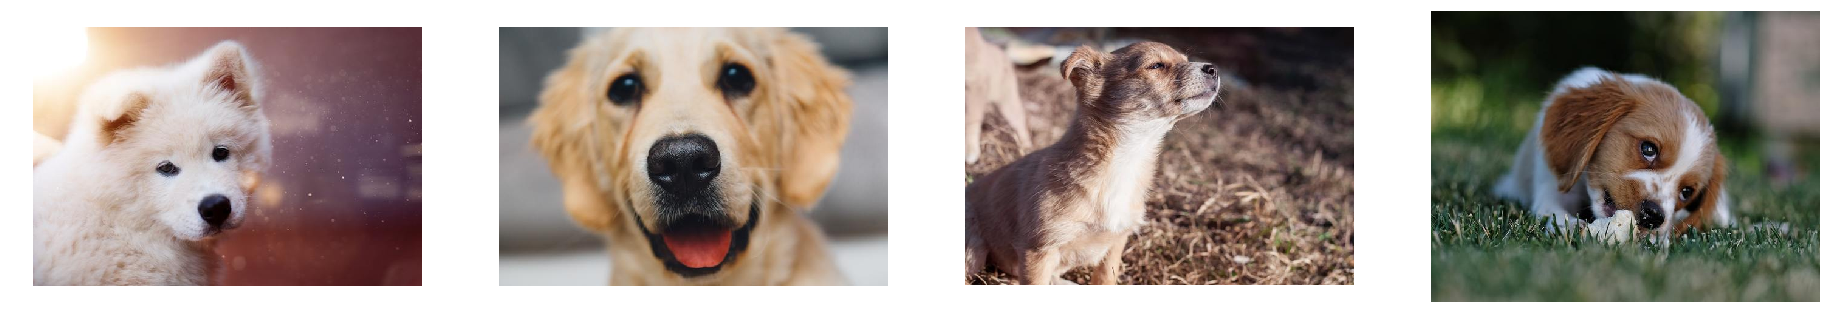

In [2]:
class ImageDecoderPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(ImageDecoderPipeline, self).__init__(batch_size, num_threads, device_id, seed = seed)
        self.input = ops.FileReader(file_root = image_dir)
        self.decode = ops.ImageDecoder(device = 'cpu', output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        return (images, labels)
    
pipe = ImageDecoderPipeline(batch_size, 1, 0)
pipe.build()
images, _ = pipe.run()
show_images( images )

## Image Decoder (CPU) with random cropping window size and anchor

'ImageDecoderRandomCrop' produces a randomly cropped image. The random cropping window is produced based on a given aspect ratio and area distributions.

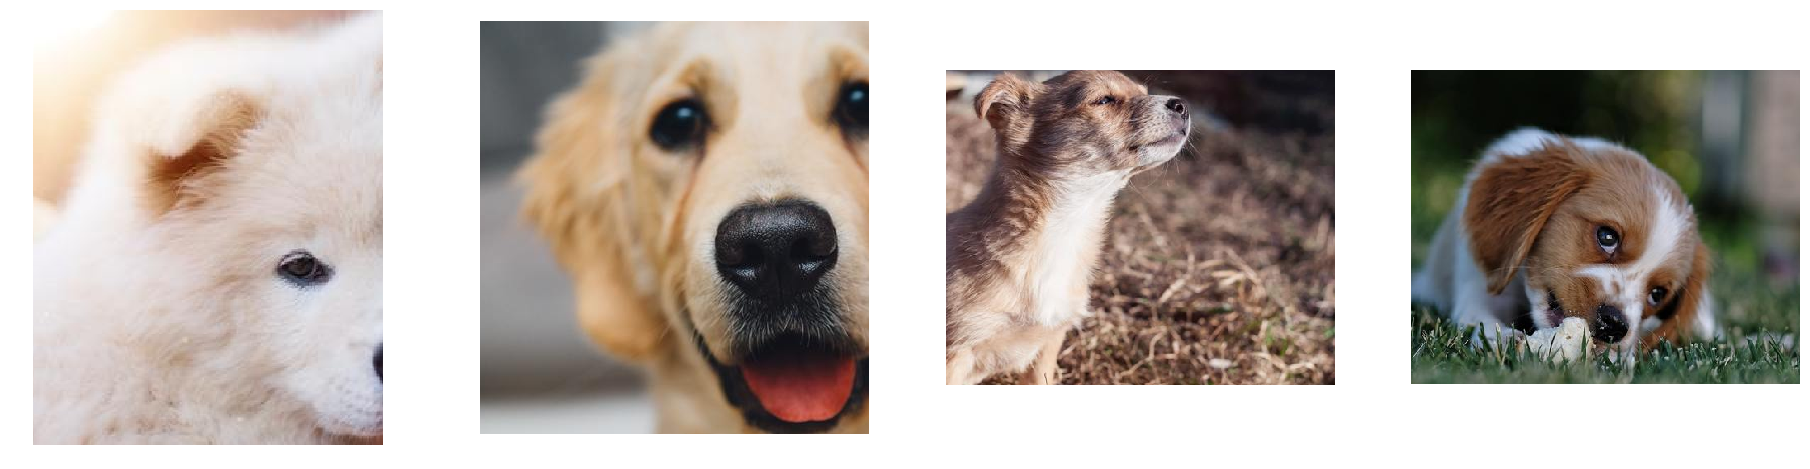

In [3]:
class ImageDecoderRandomCropPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(ImageDecoderRandomCropPipeline, self).__init__(batch_size, num_threads, device_id, seed = seed)
        self.input = ops.FileReader(file_root = image_dir)
        self.decode = ops.ImageDecoderRandomCrop(
            device="cpu",
            output_type=types.RGB,
            random_aspect_ratio=[0.8, 1.25],
            random_area=[0.1, 1.0],
            num_attempts=100)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        return (images, labels)
    
pipe = ImageDecoderRandomCropPipeline(batch_size, 1, 0)
pipe.build()
images, _ = pipe.run()
show_images( images )

## Image Decoder with fixed cropping window size and external anchor

'ImageDecoderCrop' produces a cropped image with a fixed cropping window size and a variable position

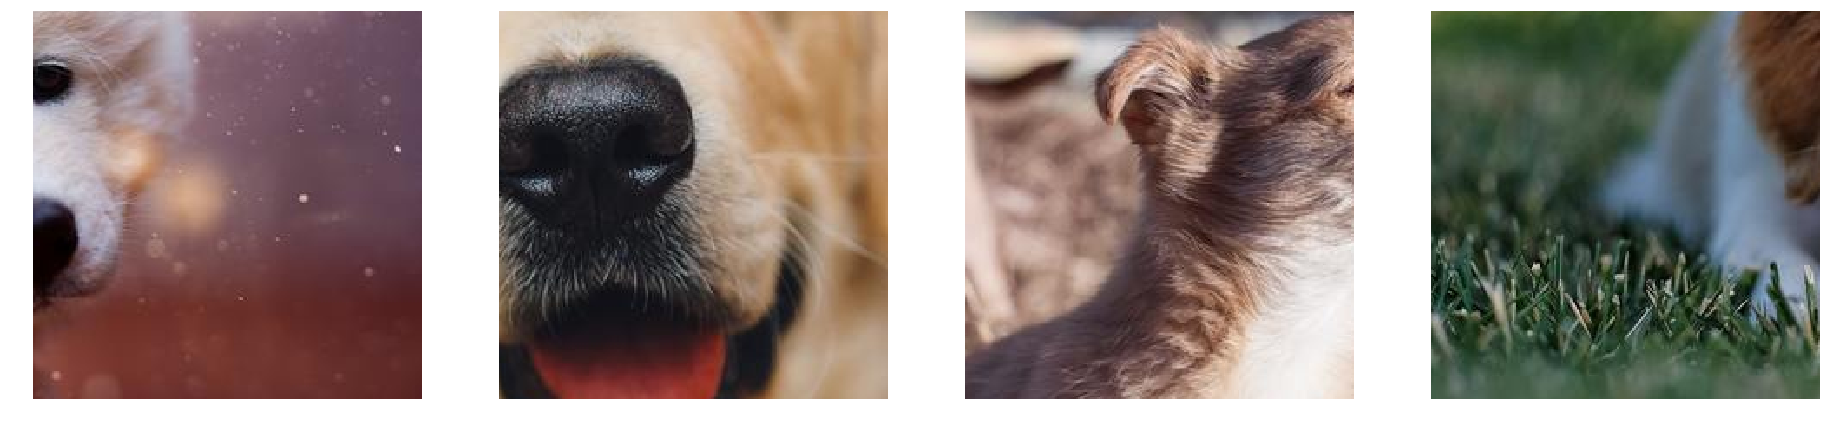

In [4]:
class ImageDecoderCropPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(ImageDecoderCropPipeline, self).__init__(batch_size, num_threads, device_id, seed = seed)
        self.input = ops.FileReader(file_root = image_dir)
        self.pos_rng_x = ops.Uniform(range = (0.0, 1.0))
        self.pos_rng_y = ops.Uniform(range = (0.0, 1.0))
        self.decode = ops.ImageDecoderCrop(device = 'cpu', output_type = types.RGB, crop = (224, 224))

    def define_graph(self):
        jpegs, labels = self.input()
        pos_x = self.pos_rng_x()
        pos_y = self.pos_rng_y()
        images = self.decode(jpegs, crop_pos_x=pos_x, crop_pos_y=pos_y)
        return (images, labels)
    
pipe = ImageDecoderCropPipeline(batch_size, 1, 0)
pipe.build()
images, _ = pipe.run()
show_images( images )

## Image Decoder (CPU) with external window size and anchor

'ImageDecoderSlice' produces a cropped image based on additional tensor inputs describing the cropping window size and position

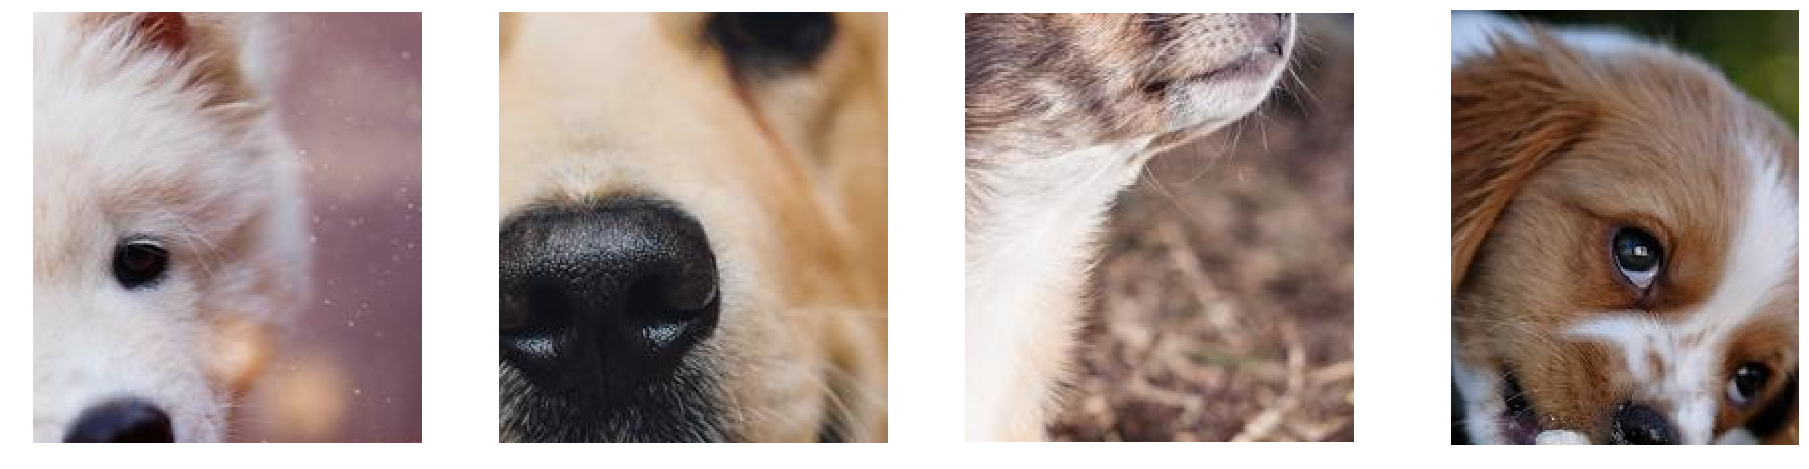

In [5]:
import numpy as np

class ExternalInputIterator(object):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        
    def __iter__(self):
        self.i = 0
        self.n = self.batch_size
        return self

    def __next__(self):
        pos = []
        size = []
        for _ in range(self.batch_size):
            pos.append(np.asarray([0.4, 0.2], dtype=np.float32))
            size.append(np.asarray([0.3, 0.5], dtype=np.float32))
            self.i = (self.i + 1) % self.n
        return (pos, size)
    
    next = __next__

eii = ExternalInputIterator(batch_size)
pos_size_iter = iter(eii)
    
class ImageDecoderSlicePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(ImageDecoderSlicePipeline, self).__init__(batch_size, num_threads, device_id, seed = seed)

        self.input = ops.FileReader(file_root = image_dir)
        self.input_crop_pos = ops.ExternalSource()
        self.input_crop_size = ops.ExternalSource()
        self.input_crop = ops.ExternalSource()
        self.decode = ops.ImageDecoderSlice(device = 'cpu', output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        self.crop_pos = self.input_crop_pos()
        self.crop_size = self.input_crop_size()
        images = self.decode(jpegs, self.crop_pos, self.crop_size)
        return (images, labels)
    
    def iter_setup(self):
        (crop_pos, crop_size) = pos_size_iter.next()
        self.feed_input(self.crop_pos, crop_pos)
        self.feed_input(self.crop_size, crop_size)
    
pipe = ImageDecoderSlicePipeline(batch_size, 1, 0)
pipe.build()
images, _ = pipe.run()
show_images( images )

# Image Decoder (Hybrid)

`ImageDecoder` decodes the whole image (no cropping)

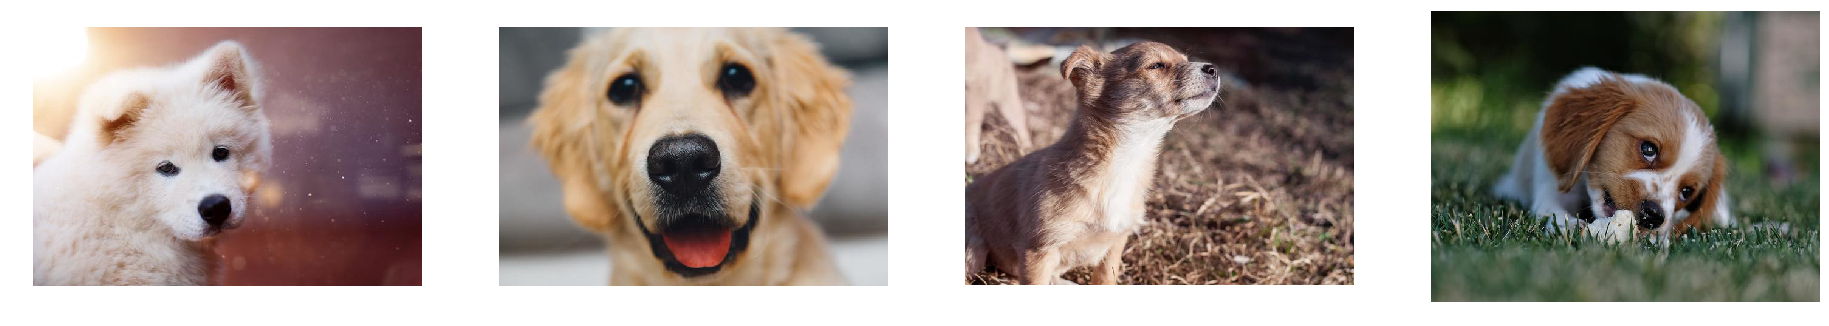

In [6]:
class ImageDecoderPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(ImageDecoderPipeline, self).__init__(batch_size, num_threads, device_id, seed = seed)
        self.input = ops.FileReader(file_root = image_dir)
        self.decode = ops.ImageDecoder(device = 'mixed', output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        return (images, labels)
    
pipe = ImageDecoderPipeline(batch_size, 1, 0)
pipe.build()
images, _ = pipe.run()
show_images( images.as_cpu() )

## Image Decoder (Hybrid) with random cropping window size and anchor

'ImageDecoderRandomCrop' produces a randomly cropped image. The random cropping window is produced based on a given aspect ratio and area distributions.

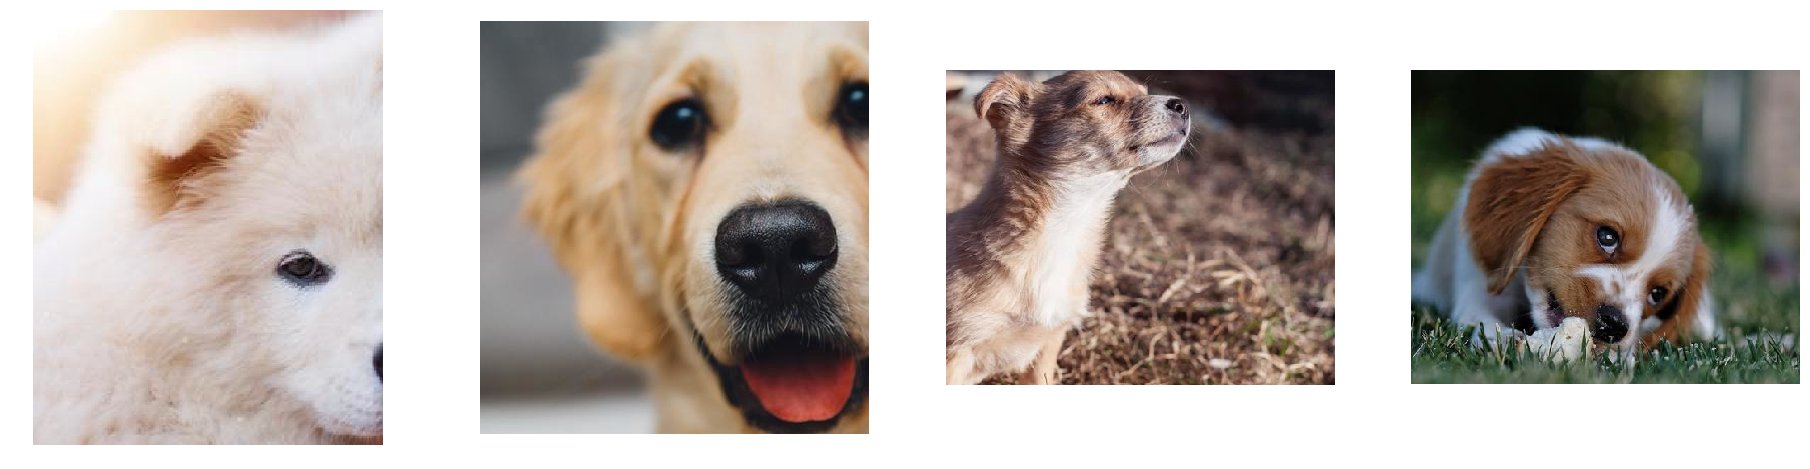

In [7]:
class ImageDecoderRandomCropPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(ImageDecoderRandomCropPipeline, self).__init__(batch_size, num_threads, device_id, seed = seed)
        self.input = ops.FileReader(file_root = image_dir)
        self.decode = ops.ImageDecoderRandomCrop(
            device="mixed",
            output_type=types.RGB,
            random_aspect_ratio=[0.8, 1.25],
            random_area=[0.1, 1.0],
            num_attempts=100)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        return (images, labels)
    
pipe = ImageDecoderRandomCropPipeline(batch_size, 1, 0)
pipe.build()
images, _ = pipe.run()
show_images( images.as_cpu() )

## Image Decoder (Hybrid) with fixed cropping window size and external anchor

'ImageDecoderCrop' produces a cropped image with a fixed cropping window size and a variable position


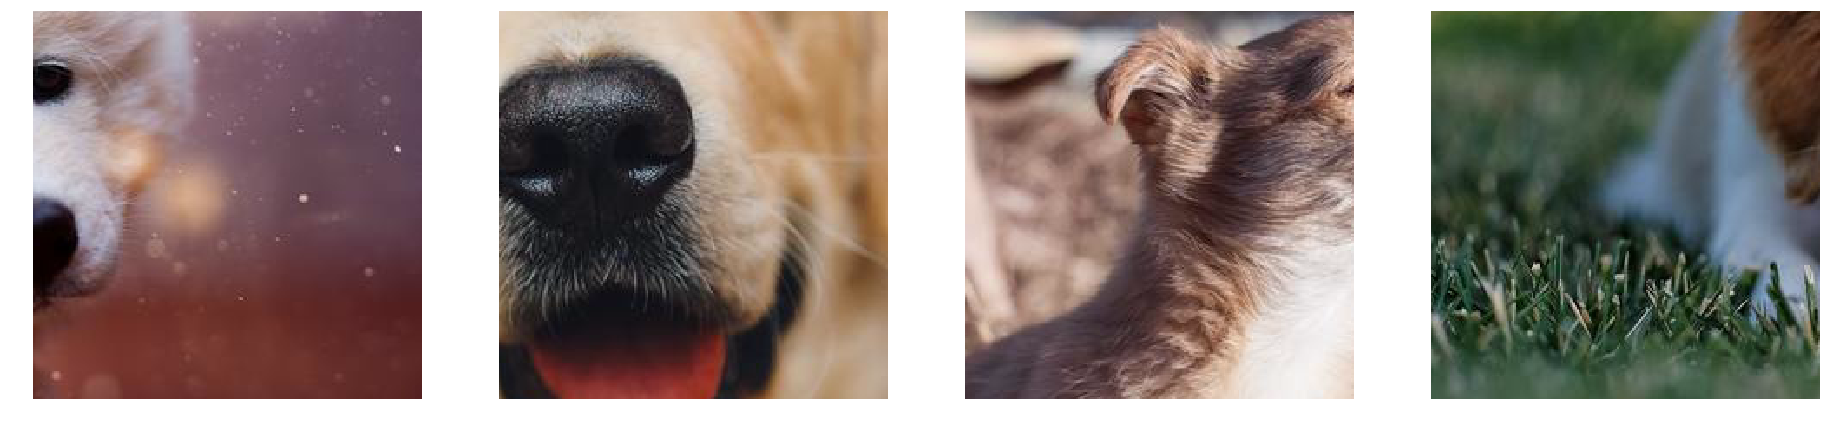

In [8]:
class ImageDecoderCropPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(ImageDecoderCropPipeline, self).__init__(batch_size, num_threads, device_id, seed = seed)
        self.input = ops.FileReader(file_root = image_dir)
        self.pos_rng_x = ops.Uniform(range = (0.0, 1.0))
        self.pos_rng_y = ops.Uniform(range = (0.0, 1.0))
        self.decode = ops.ImageDecoderCrop(device = 'mixed', output_type = types.RGB, crop = (224, 224))

    def define_graph(self):
        jpegs, labels = self.input()
        pos_x = self.pos_rng_x()
        pos_y = self.pos_rng_y()
        images = self.decode(jpegs, crop_pos_x=pos_x, crop_pos_y=pos_y)
        return (images, labels)
    
pipe = ImageDecoderCropPipeline(batch_size, 1, 0)
pipe.build()
images, _ = pipe.run()
show_images( images.as_cpu() )

## Image Decoder (Hybrid) with external window size and anchor

'ImageDecoderSlice' produces a cropped image based on additional tensor inputs describing the cropping window size and position

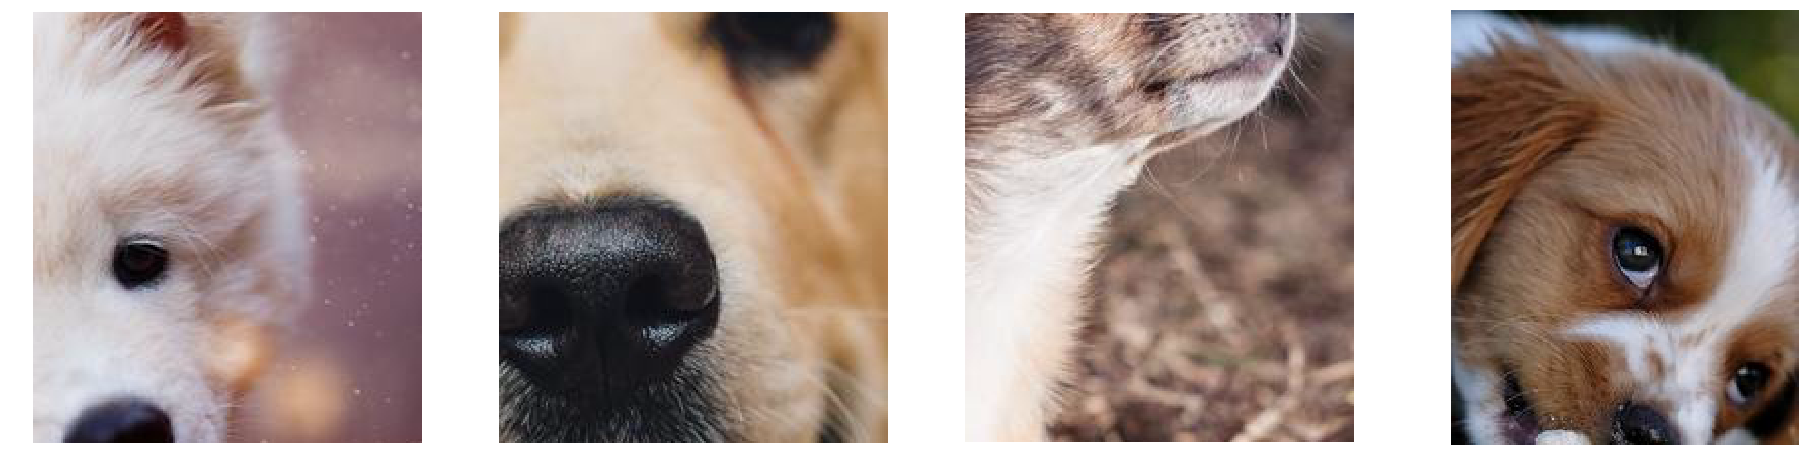

In [9]:
import numpy as np

class ExternalInputIterator(object):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        
    def __iter__(self):
        self.i = 0
        self.n = self.batch_size
        return self

    def __next__(self):
        pos = []
        size = []
        for _ in range(self.batch_size):
            pos.append(np.asarray([0.4, 0.2], dtype=np.float32))
            size.append(np.asarray([0.3, 0.5], dtype=np.float32))
            self.i = (self.i + 1) % self.n
        return (pos, size)
    
    next = __next__

eii = ExternalInputIterator(batch_size)
pos_size_iter = iter(eii)
    
class ImageDecoderSlicePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(ImageDecoderSlicePipeline, self).__init__(batch_size, num_threads, device_id, seed = seed)

        self.input = ops.FileReader(file_root = image_dir)
        self.input_crop_pos = ops.ExternalSource()
        self.input_crop_size = ops.ExternalSource()
        self.input_crop = ops.ExternalSource()
        self.decode = ops.ImageDecoderSlice(device = 'mixed', output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        self.crop_pos = self.input_crop_pos()
        self.crop_size = self.input_crop_size()
        images = self.decode(jpegs, self.crop_pos, self.crop_size)
        return (images, labels)
    
    def iter_setup(self):
        (crop_pos, crop_size) = pos_size_iter.next()
        self.feed_input(self.crop_pos, crop_pos)
        self.feed_input(self.crop_size, crop_size)
    
pipe = ImageDecoderSlicePipeline(batch_size, 1, 0)
pipe.build()
images, _ = pipe.run()
show_images( images.as_cpu() )